<a href="https://colab.research.google.com/github/Peritec-Corp/IoTSolution/blob/main/Setup_KVM_Server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 前提

CentOS8上にUbuntuを入れ、その上に Docker を構築して\
MQTTサーバー1つ、Node-RED 複数をセットアップします。

- 下OS情報
```
[root@kvmbase ~]# hostnamectl
   Static hostname: kvmbase
         Icon name: computer-server
           Chassis: server
        Machine ID: 1123b93b58904d8395b1d48cc887185f
           Boot ID: 1efddf0014ae45f1873ac172ec927067
  Operating System: CentOS Linux 8
       CPE OS Name: cpe:/o:centos:centos:8
            Kernel: Linux 4.18.0-348.7.1.el8_5.x86_64
      Architecture: x86-64
```

- OSのインストール方法は以下を参考にした模様\
https://www.rem-system.com/centos77-install/

- Cockpit のセットアップが完了していること\
(http://[IPアドレス]:9090 でアクセスできること)\
動作しない場合は、https://qiita.com/fy406/items/d6dbadce6d892826740e などを参照

- この資料は Public 公開されているので、パスワードは伏せる\
　パスワードは社内サーバーの\
　個人ファイル\takanami\Setup KVM Server.ipynb パスワード.txt においておく
　

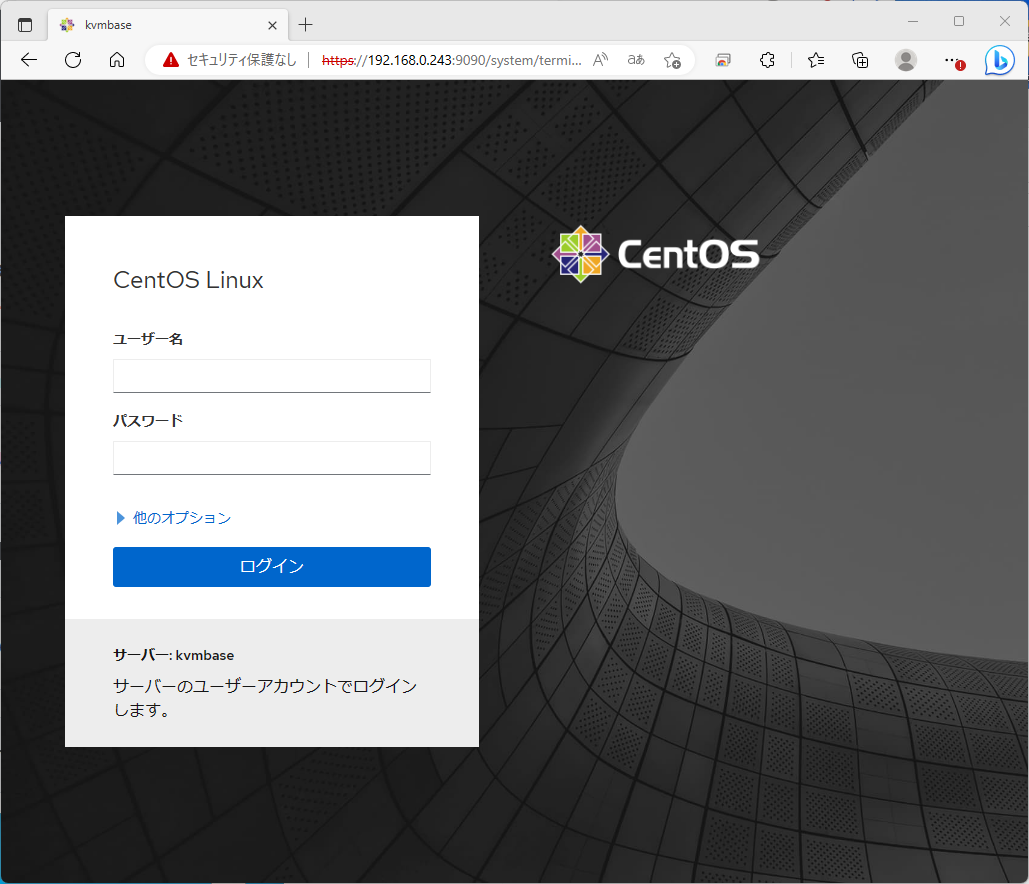

---
# CentOS のアップデート

次を参照した (https://www.rem-system.com/linux-first-setting/)

- パッケージのインポート
```
 yum check-update
```

以下のようなエラーが発生した。\
<font color="red">エラー: Failed to download metadata for repo 'AppStream': 
Cannot prepare internal mirrorlist: No URLs in mirrorlist</font>

以下を参照して対応、アップデートに成功\
(https://qiita.com/yamada-hakase/items/cb1b6124e11ca65e2a2b) 

CentOS-Base.repo, CentOS-AppStream.repoを修正

```
vi /etc/yum.repos.d/CentOS-Base.repo
```
以下のように書き換え
```
baseurl=http://mirror.centos.org/$contentdir/$releasever/BaseOS/$basearch/os/
↓
baseurl=http://vault.centos.org/$contentdir/$releasever/BaseOS/$basearch/os/
```


```
vi /etc/yum.repos.d/CentOS-Base.repo
```
以下のように書き換え
```
baseurl=http://mirror.centos.org/$contentdir/$releasever/AppStream/$basearch/os/
↓
baseurl=http://vault.centos.org/$contentdir/$releasever/AppStream/$basearch/os/
```


書き換え後、CockpitのUIからアップデートしたところ、\
アップデートが実行され、CnetOS-Linux-*.repo にファイル名が変更された

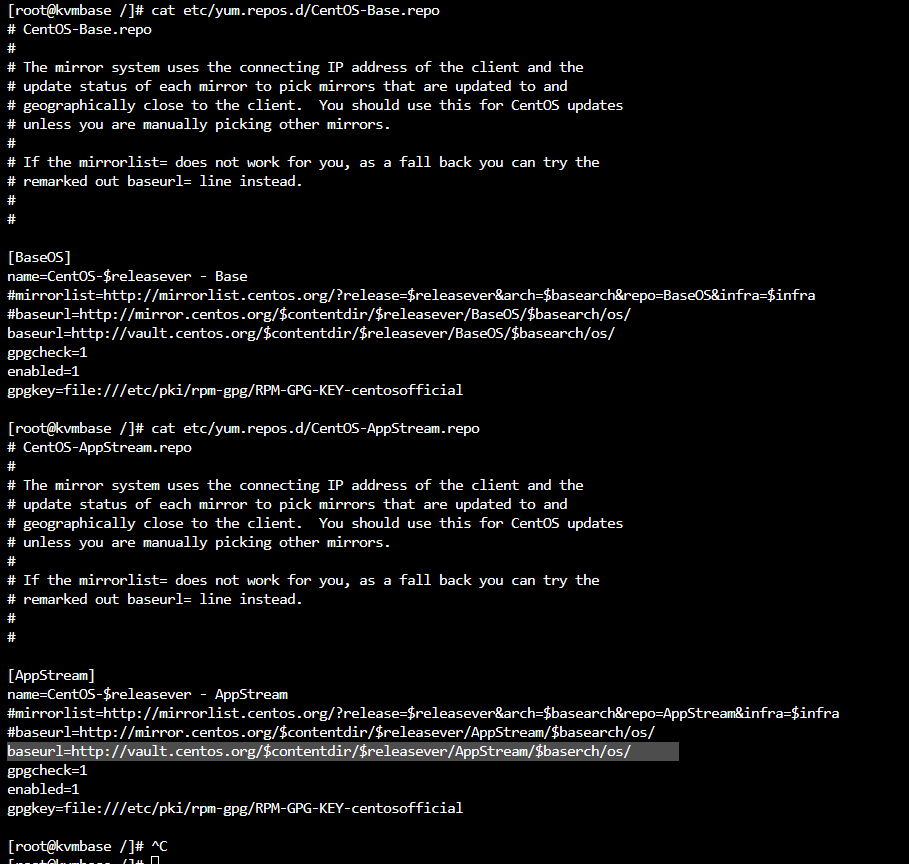


---
# CentOSのWifi設定

本PCには、LANポートが2つあったが、1つが使用する設定になっていなかったため使用する設定にした。

コンソールから以下を実行
```
nmtui
```

1. Edit connection を選択
2. \<Add> から Bridge を選択
- Profile name : br1
- Device : br1
- EnableSTP:False
- Addresses : 192.168.254.243/24 (固定IPにする)
- Gateway : 192.168.254.1
- DNS servers : 192.168.254.1

- Slavesで\<Add>、Ethernetを選択\
Profile name : eno1
Device : eno1 (2C:EA:7F:4C:A8:68)　（Gb1側のmacアドレス）

コンソールまで戻り、
```
systemctl restart NetworkManager
```

仮想環境作成後、ブラウザからcockpictでアクセス\
仮想マシンを選択して、ネットワークに対象の br1 がないなら「ネットワークインターフェイスの追加」\
(ネットワーク設定を仮想環境作成後に行ったため、本処理が必要になったかもしれない)


- インターフェース形式：Bridge to LAN
- ソース：br1
- モデル：(Linux, perf)
- MACアドレス：自動生成
- 永続チェックを入れる

アクセスできることを確認する\
つながらなかったら一度再起動する

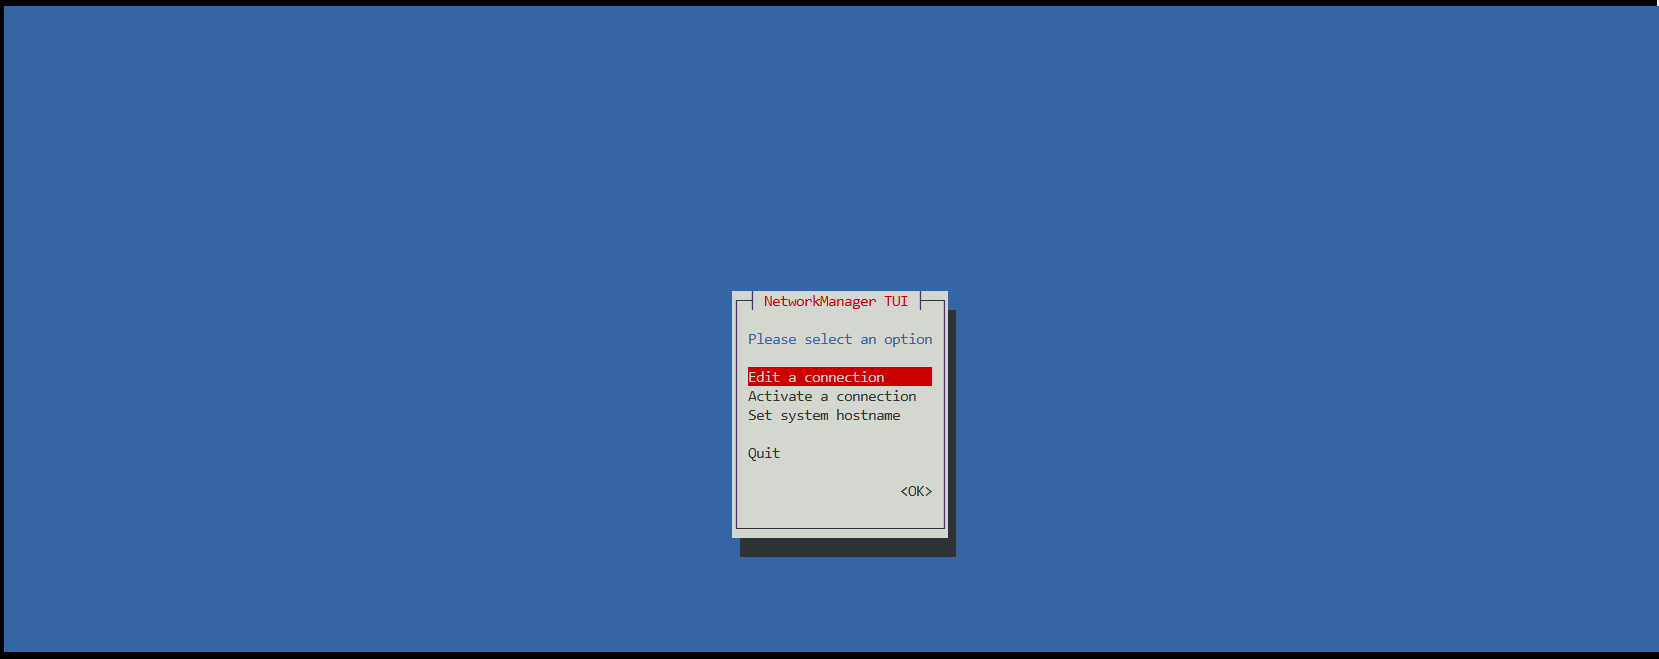

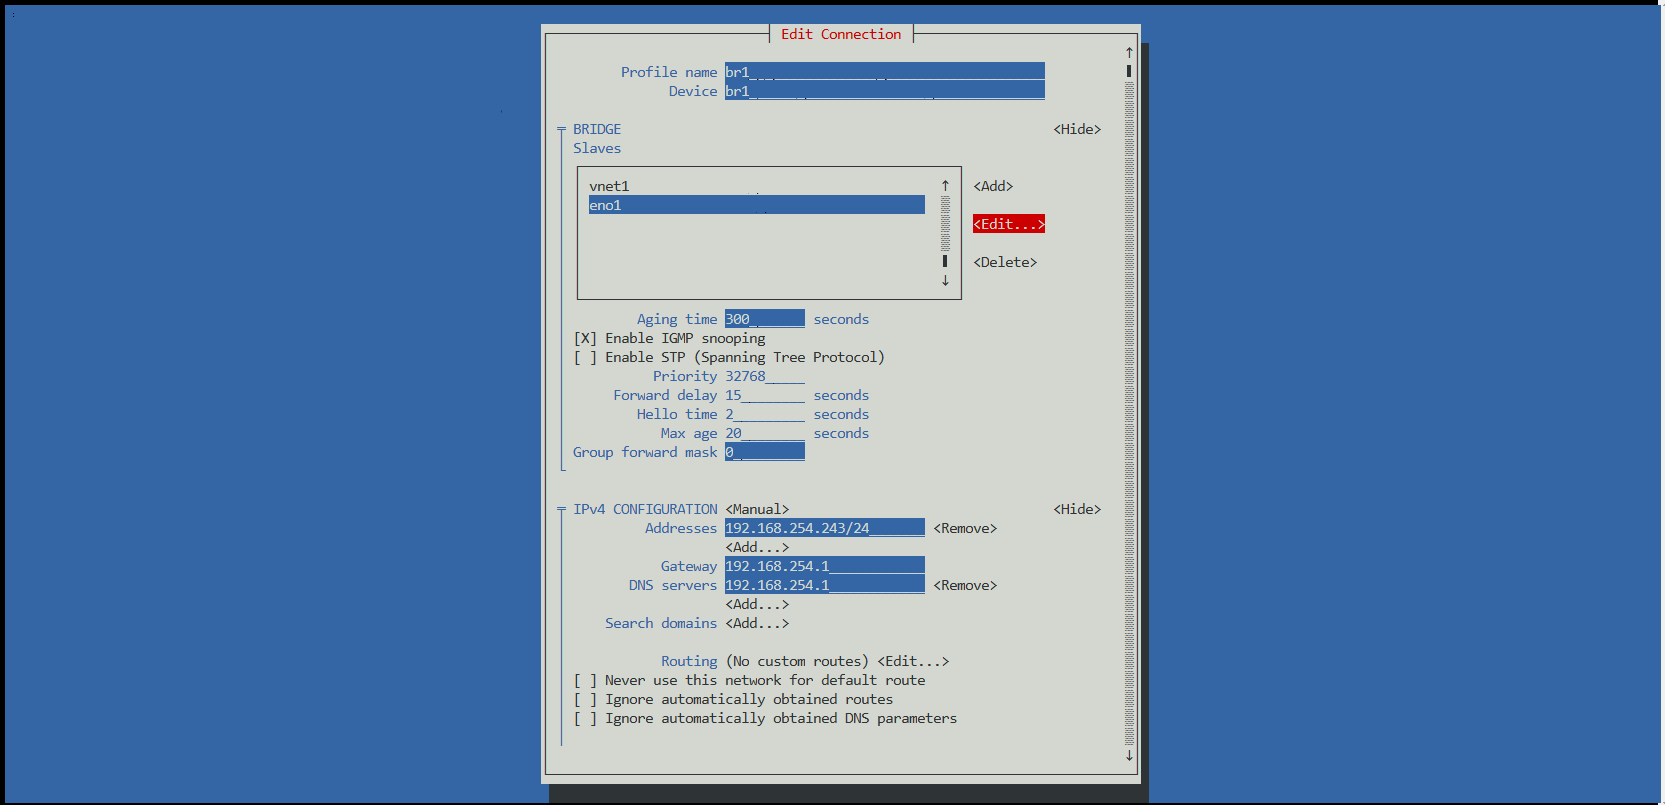

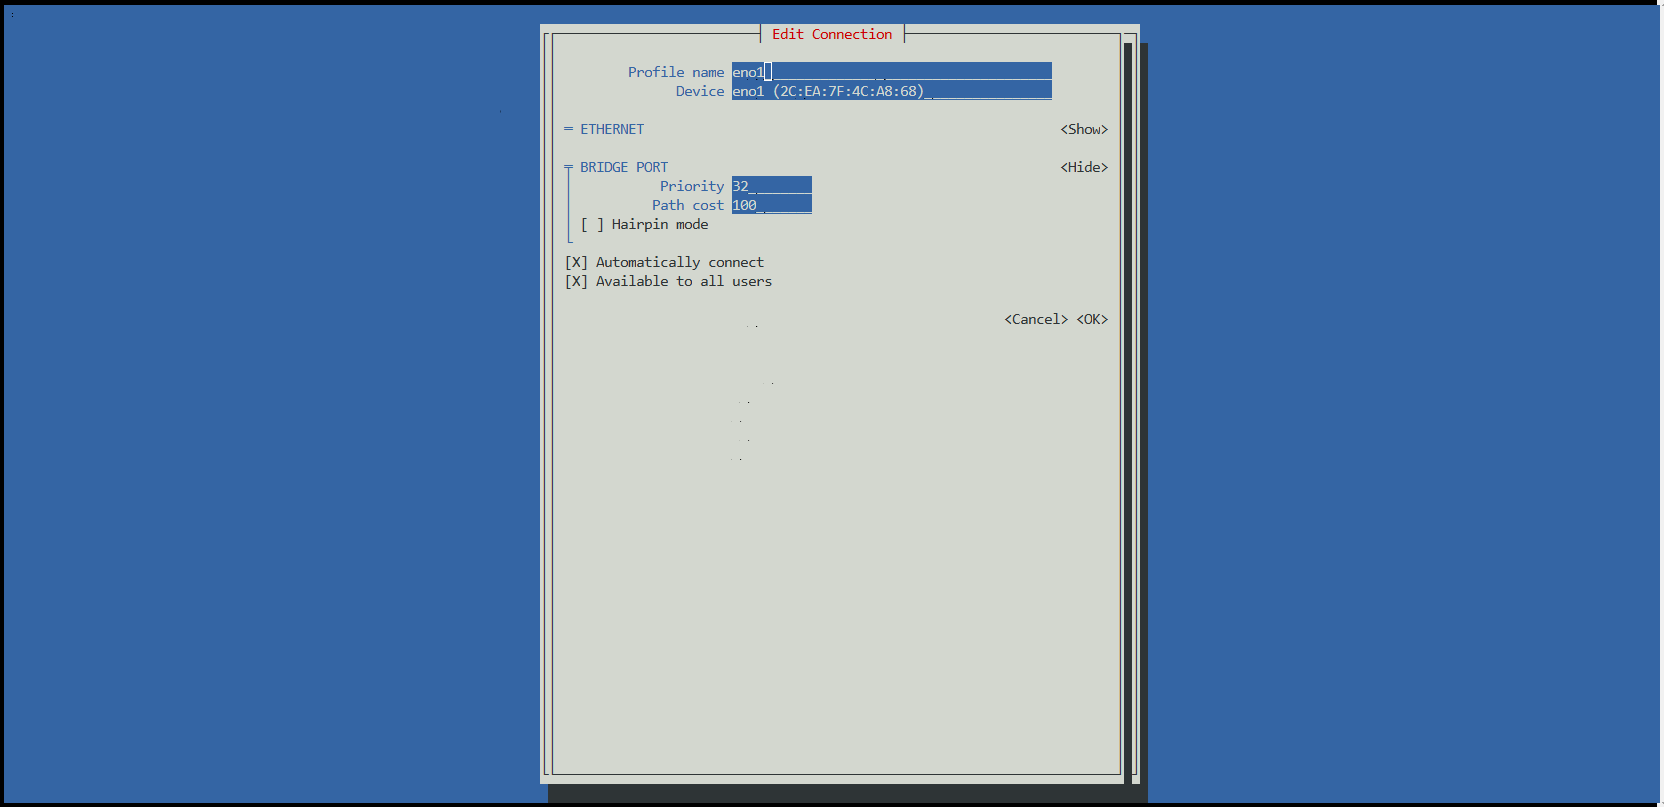

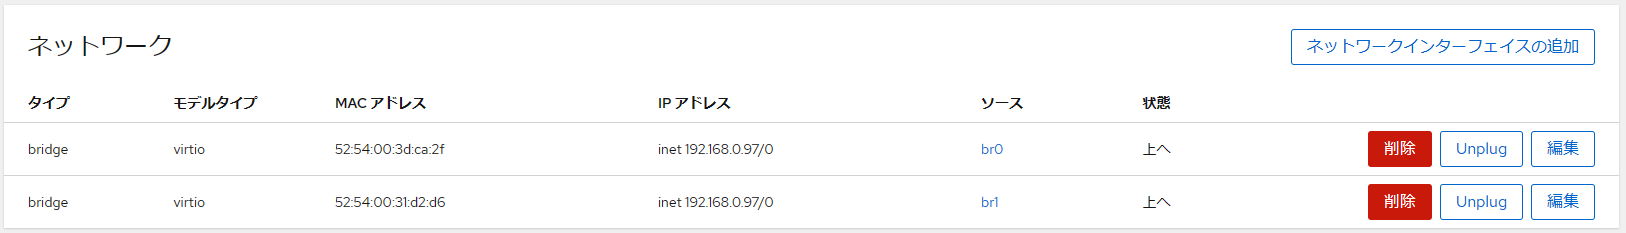

---
# 仮想環境作成

ブラウザから 仮想マシン -> 仮想マシン作成

- 名前：IoTSchool
- インストールタイプ：ダウンロード
- オペレーティングシステム：Ubuntu 20.04 LTS
- ストレージ：ボリュームの新規作成
- サイズ：300GiB
- メモリ：32GiB
- 無人インストール実行：False
- 仮想マシンをすぐに起動：True


エラーが発生した。

<font color=red>VM IoTSchool の作成に失敗 
ERROR Error validating install location: Could not find an installable distribution at 'http://archive.ubuntu.com/ubuntu/dists/focal/main/installer-amd64' The location must be the root directory of an install tree. See virt-install man page for various distro examples.<font>


ダウンロードパスに異常があるようなので\
ubuntuのイメージを手動で設定して、再度仮想マシンを作成する

- インストールタイプ：URL
- インストールソース：https://releases.ubuntu.com/20.04/ubuntu-20.04.6-live-server-amd64.iso 
- オペレーティングシステム：Ubuntu 20.04 LTS
- ストレージ：ボリュームの新規作成
- サイズ：300GiB
- メモリ：32GiB
- 無人インストール実行：False
- 仮想マシンをすぐに起動：True

長時間待つとセットアップ画面が始まる。

---
# Ubuntu Server のインストール

以下の指示通りにインストールを進める\
https://www.server-memo.net/ubuntu/ubuntu-server-2004_install.html

IPアドレスはデフォルト

- ユーザー作成\
Your name: 空\
Your server's name: iotschool\
Pick a username: peritec\
Choose a password: \*\*\*\*\*\*\*\*\*\*\*\
(Public公開なので伏字)

インストールパッケージの選択では dockerが選択肢にあるが、ここではインストールしない

全ての設定を行った後、reboot now で再起動

<font color=red>Failed unmounting /cdromエラー</font>は何も変更せずにエンター

再起動後ログイン成功

---
# ネットワーク設定
(https://qiita.com/zen3/items/757f96cbe522a9ad397d)

ipアドレスを固定する

```
sudo vim /etc/netplan/99-network-config.yaml
```

ファイル内容に以下を記述\
enp7s0 はnuroネットワークに刺さっている側のLanポート\
名前は ip a コマンドから調べた
```
network:
  version: 2
  ethernets:
    enp7s0:
      dhsp4: false
      addresss: [192.168.254.245/24]
      gateway4: 192.168.254.1
      nameservers:
        addresses: [192.168.254.1]
```

変更を反映
```
sudo netplan try --timeout 180
```

---
#ポート開放のルーターの設定

Yamahaルーターからサーバーの 80 ポートを開放する

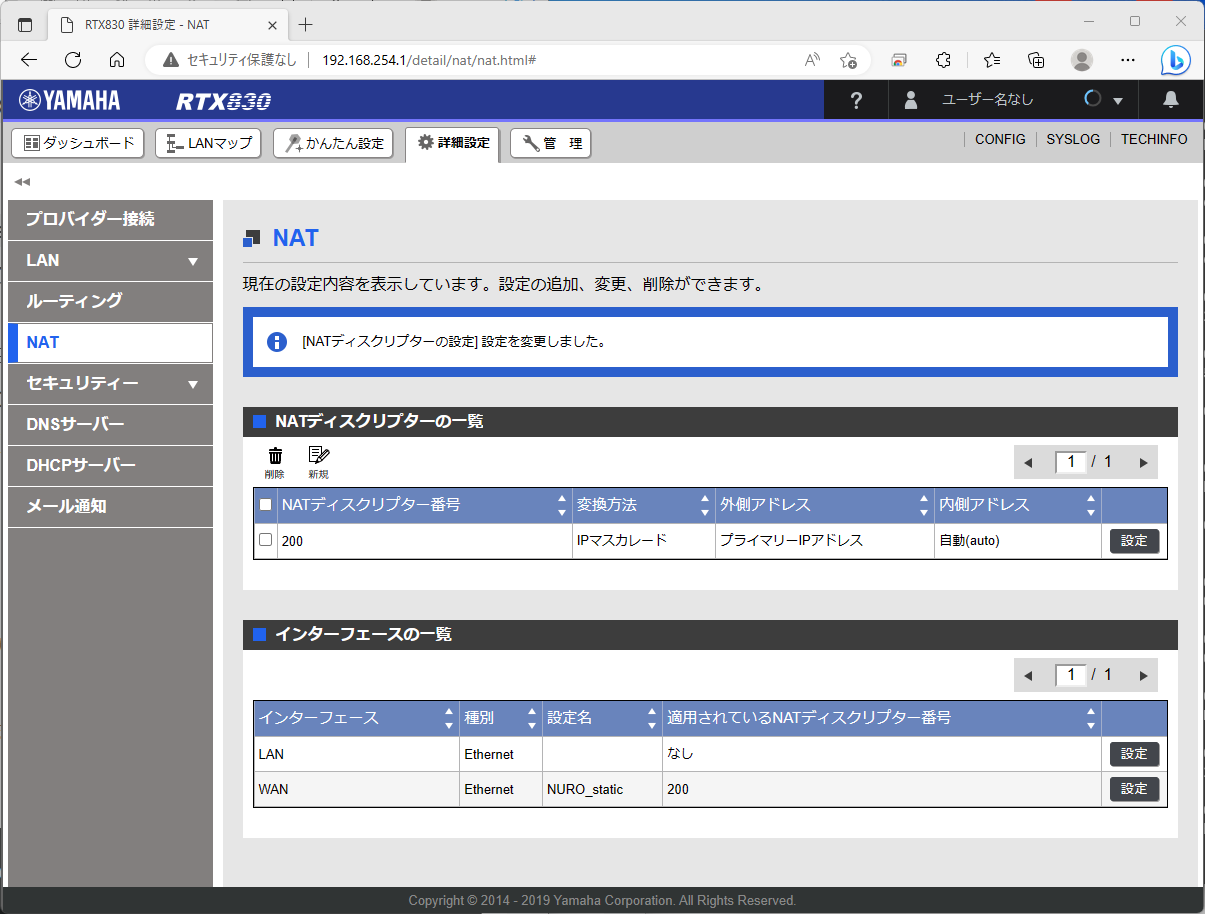


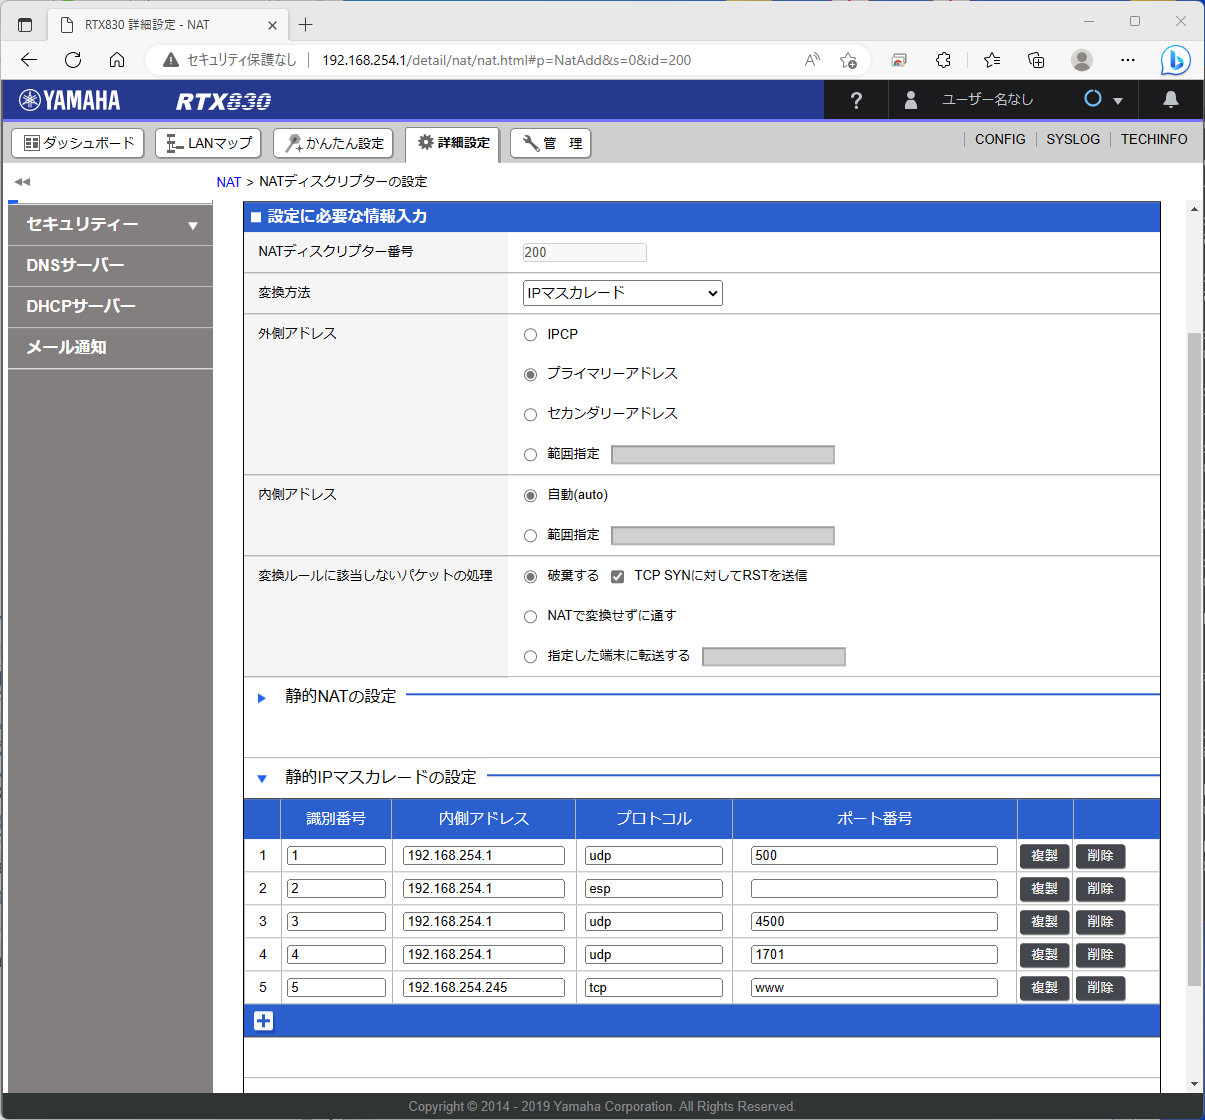

---
# Ubuntu Server 環境セットアップ

## SSH でアクセスできるように avahi-daemonのインストール
```
sudo apt install avahi-daemon
systemctl status avahi-daemon
```
(https://zenn.dev/nemuki/articles/80a75810d778a4)

別のPCを同じネットワークに接続し、コマンドラインから
```
ssh peritec@iotschool
```
でアクセスできる。

リモートからもアクセスできるようにしているがここでは省略

---
## ソフトのアップデート
```
sudo apt update
sudo apt upgrade
```

---
## Docker のインストール
以下のリポジトリを利用したインストールを実行\
(https://matsuand.github.io/docs.docker.jp.onthefly/engine/install/ubuntu/)

####リポジトリのセットアップ
```
sudo apt-get remove docker docker-engine docker.io containerd runc
sudo apt-get update
sudo apt-get install ca-certificates curl gnupg lsb-release
curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo gpg --dearmor -o /usr/share/keyrings/docker-archive-keyring.gpg
echo "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/docker-archive-keyring.gpg] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable" | sudo tee /etc/apt/sources.list.d/docker.list > /dev/null
```

#### Docker Engine のインストール
```
sudo apt-get update
sudo apt-get install docker-ce docker-ce-cli containerd.io docker-compose-plugin
```

#### Docker Engine の確認
```
sudo systemctl status docker
sudo docker run hello-world
```

#### Dockerをsudoなしで使う
参考(https://qiita.com/DQNEO/items/da5df074c48b012152ee)
```
sudo groupadd docker
sudo gpasswd -a $USER docker
sudo systemctl restart docker
exit (再ログイン)
```


#### イメージをダウンロード
```
docker image pull nginx
docker image pull nodered/node-red
```

#### nodered/node-redの起動確認
```
docker run -itd -p 1881:1880 -v node_red_data:/data --name mynodered nodered/node-red
```
http://[IPアドレス]:1881 からNodeRedにアクセスできることを確認する

#### Nginxの起動確認
```
docker run -itd -p 8888:80 --name nginx nginx
```
http://[IPアドレス]:8888/ からNginxにアクセスできることを確認する


---
# Docker Compose の設定

青木先生のDocker Compose設定を持ってくる
```
git clone https://github.com/YukiAoki-GU/nginx-nr
cd nginx-nr
docker compose up -d --build
```
http://iotschool/s01/ \
http://iotschool/s02/ \
でアクセスできること

Dockerの終了コマンド
```
docker compose down --rmi all --volumes --remove-orphans
```

---
# Broker用意

青木先生の設定にBroker用設定を追加\
```
cd ~/nginx-nr
mkdir mosquitto
cd mosquitto
vim mosquitto.conf
vim Dockerfile
vim password.txt
```

設定ファイル(mosquitto.conf)を作成
```
set_tcp_nodelay true
listener 1883
#allow_anonymous true
allow_anonymous false
password_file /mosquitto/config/password.txt
```

DockerFileを作成
```
FROM eclipse-mosquitto
COPY ./mosquitto.conf /mosquitto/config/
COPY ./password.txt /mosquitto/config/
```

パスワードファイルを作成
```
iot:$7$101$tfgUgEUtpbykmjK4$QDhvYztBc+uaoZd+5HJnGb7YvgHukowunIUT1EHDXnwJdAe3nAkBoU/fvPaVZn0+BVXIKrMCakrMNVMUl/jsJw==
```

docker-compose.ymlファイルにDocker-Compose設定を追加
```
# Broker
broker:
  build:
    context : ./mosquitto/
    dockerfile: Dockerfile
  container_name: broker
  ports:
    - 1883:1883
```

dockerを起動する
```
docker compose up -d --build
docker compose down --rmi all --volumes --remove-orphans
```

サーバー上のNode-Redから以下設定でMQTTサーバーが利用できること
- サーバー：broker
- ポート:1883
- ユーザー名：iot
- パスワード：\*\*\*\*\*\*\*\*\*\*

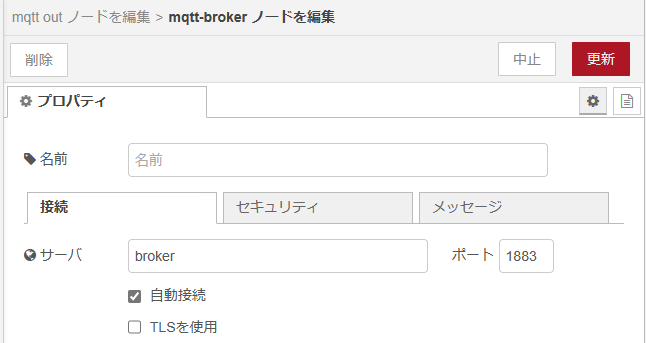

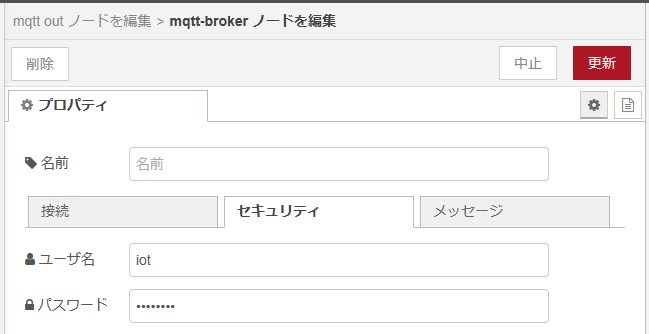

## Brokerのパスワードを設定する

MQTTサーバーにアクセス
```
docker exec -it broker sh
cd mosquitto/config/
```

パスワードファイルを作成し、以下のように入力
```
[ユーザー名]:[パスワード]
```

以下で同ファイルがパスワード化されること
```
mosquitto_passwd -U password.txt
```

コンテナから抜け、以下でファイルを取り出す。
```
docker cp broker:/mosquitto/config/[ファイル名] .
```

# <font color="red">内側からグローバルIPで指定ができない</font>

Node-RedでMQTTサーバーをIPアドレスで指定するとサーバーと通信することができなかった。\
一度ルータから外に出た時に異常がある様子があるので、
ルーティングテーブルを指定して、外に出ないようにする。

docker-compose.yml に追記する。
s01、s02の項目に以下を追記
```
extra_hosts:
  - "peritec.net:192.168.254.245"
```

docker の再起動後、サーバーをIPアドレスで指定して通信ができること

# Brokerにサブドメインでアクセスする

Brokerにnginxを通して80番ポートでアクセスできるようにする。

```
cd ~/nginx-nr/nginx
vim default.conf
```
設定ファイルに以下を追記する
```
  location /mqtt/ {
    proxy_pass http://broker:1883/;
  }
```

Node-Redから以下の設定でアクセスできること
- サーバー：[IPアドレス]/mqtt/
- ポート：80

---  
# <font color="red">ラズパイで teachable machine が機能しない</font>

node-red-contrib-teachable-machine をインストールしても\
MODULE_NOT_FOUND となって使用ができない

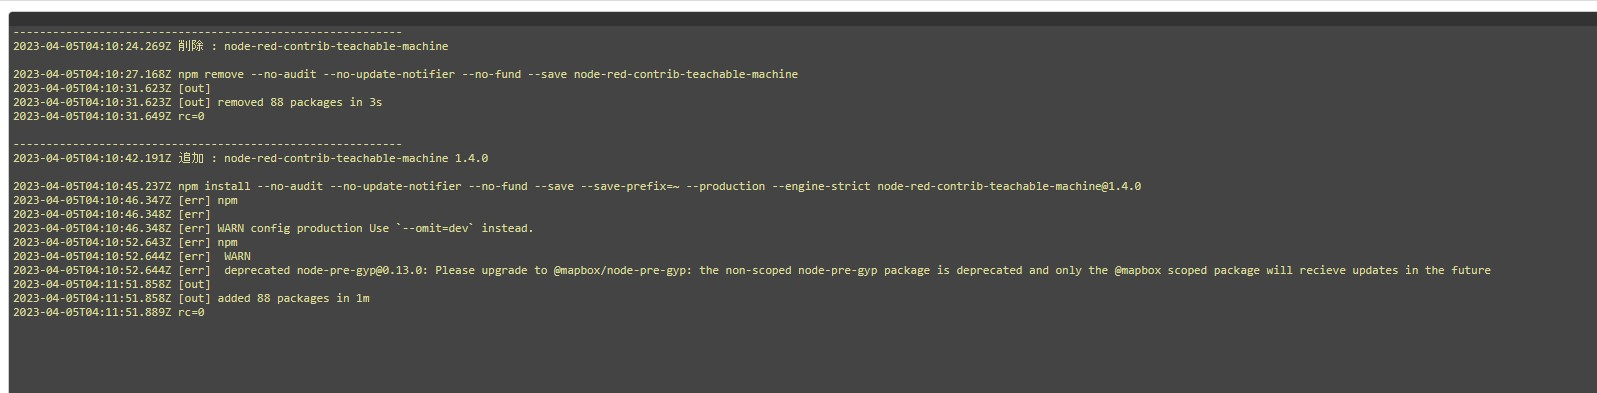

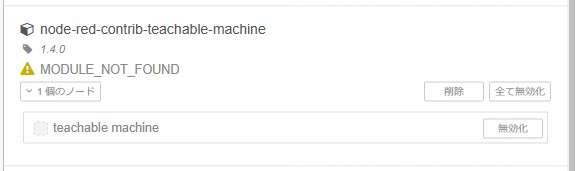

新しいバージョンであることが問題らしいので古いバージョンをインストールする
```
cd ~/.node-red
npm install node-red-contrib-teachable-machine@1.3
```

---
# (メモ)自作コマンド定義

```
echo alias docker-up=\'docker compose up -d --build\' >> ~/.bashrc
echo alias docker-down=\'docker compose down --rmi all --volumes --remove-orphans\' >> ~/.bashrc
```